## Protótipo: Predição de Morte por Genes em Câncer de Mama

### Objetivo
Este projeto é um **protótipo de protótipo** que demonstra a construção de um modelo de machine learning para prever a morte de pacientes com câncer de mama com base em mutações genéticas.

### Dataset
- Número de pacientes: 1800
- Tipo de dados: genes binários (0 = ausente, 1 = presente) + status vital
- Fonte: cBioPortal - break_msk_2018

### Pipeline
1. Limpeza e organização dos dados
2. Criação de tabela binária de genes por paciente
3. Treinamento de modelo Random Forest
4. Avaliação do modelo (Accuracy, ROC AUC)
5. Feature importance para identificar genes mais decisivos

### Limitações
- Protótipo experimental, não clínico
- Apenas genes binários, sem outros fatores clínicos
- Modelo não generalizado para uso real

### Resultados
- Accuracy: 0.72
- ROC AUC: 0.61
- Top genes mais importantes: TP53, BRCA1, PIK3CA
- O modelo tem alguma capacidade de previsão, mas não é confiável.

> **Observação:** Para melhorar a predição, seriam necessários:
> - Um número maior de pacientes para treinamento
> - Uso de técnicas mais avançadas do scikit-learn (como otimização de hiperparâmetros, seleção de features, regressão logística com interações, ensemble models)
> - Inclusão de variáveis clínicas adicionais (idade, estágio do câncer, tratamentos)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [19]:
file_path = os.path.join('..','data','raw','breast_msk_2018','data_mutations.txt')
data_mutations = pd.read_csv(file_path,sep='\t')

In [20]:
file_path = os.path.join('..','data','raw','breast_msk_2018','data_clinical_patient.txt')
data_patients = pd.read_csv(file_path,sep='\t',comment='#')

In [21]:
data_mutations.columns = data_mutations.columns.str.strip()
data_patients.columns = data_patients.columns.str.strip()

In [22]:
patients =  data_patients.loc[:,['PATIENT_ID']]
patients['PATIENT_ID'] = patients['PATIENT_ID'].apply(lambda x:x.strip())

In [23]:
genes_per_patient = data_mutations.loc[:,['Tumor_Sample_Barcode','Hugo_Symbol']]
genes_per_patient.loc[:,'Tumor_Sample_Barcode'] = genes_per_patient.loc[:,'Tumor_Sample_Barcode'].str.strip()
genes_per_patient.loc[:,'Tumor_Sample_Barcode'] = genes_per_patient.loc[:,'Tumor_Sample_Barcode'].str.extract('^([^-]+-[^-]+)')
genes_per_patient.columns = ['PATIENT_ID','Gene']


In [24]:
patient_alive = data_patients.loc[:,['PATIENT_ID','VITAL_STATUS']]
patient_alive.loc[:,'VITAL_STATUS'] = patient_alive.loc[:,'VITAL_STATUS'].map({'Alive':1,'Deceased':0})

In [25]:
data = patients.merge(genes_per_patient,on='PATIENT_ID',how='left')
binary_table = data.assign(value=1).pivot_table(index='PATIENT_ID',columns='Gene',values='value',fill_value=0)
binary_table = binary_table.astype(int)
binary_table = binary_table.merge(patient_alive,on='PATIENT_ID',how='left')
binary_table.dropna(inplace=True)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report

In [27]:
X = binary_table.drop(columns = ['PATIENT_ID','VITAL_STATUS'])
y = binary_table.loc[:,'VITAL_STATUS'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
clf = RandomForestClassifier(n_estimators=250,random_state=1234)
clf.fit(X_train, y_train)

,n_estimators,250
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

In [30]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7240356083086054
ROC AUC: 0.6211089494163424

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.17      0.23        80
           1       0.78      0.89      0.83       257

    accuracy                           0.72       337
   macro avg       0.56      0.53      0.53       337
weighted avg       0.67      0.72      0.69       337



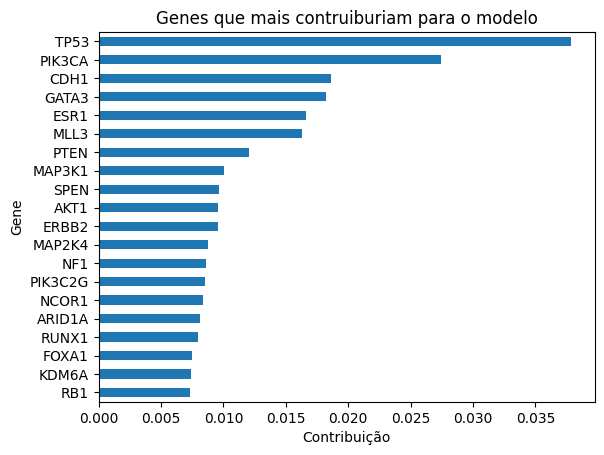

In [31]:
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
importances.head(20).plot(kind='barh')
plt.title('Genes que mais contruiburiam para o modelo')
plt.xlabel('Contribuição')
plt.ylabel('Gene')
plt.gca().invert_yaxis()
plt.show()